In [5]:
from numpy import *
import diffractio
from diffractio import sp, nm, plt, mm, degrees, um
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.utils_drawing import draw_several_fields
from scipy.special import jn
from scipy.special import jn_zeros

%matplotlib inline

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from simfuncs import * # for saving/retreiving data

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
# imagedir = os.path.join('..','images')
imagedir = os.path.join('.','paper_data')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

def check_samp(field,x1fp,x2fp,z12,w,pts,lmbda,draw=True,onlycheck=False):
    """resamples the field if necessary to the closest power of 2 to the minimum pts required
    x1fp: the largest value of x we care about in plane 1
    x2fp: same but for plane 2
    z12: the propagation distance from 1 to 2
    w: the full width in the object plane
    pts: the number of pts along one dimension of field. field assumed pts by pts.
    lmbda: the wavelength
    draw: draw the resampled field if True
    onlycheck: don't resample the field, just print the number of required pts if resampling is needed.
    returns:
        field, xpts, ypts. if field needs to be resampled, returns the resampled field. otherwise, field is simply passed out.
    """
    
    minpts = int(w*2*(x1fp + x2fp)/(lmbda*sqrt((x1fp + x2fp)**2 + z12**2))+0.5)
    print("min pts req'd:",minpts)
    print(f"current pts: {pts}")
    if minpts > pts:
        if not onlycheck:
            newpts = 2**int(log2(minpts)+0.5)
            if newpts != pts: # sometimes minpts is just slightly over pts, and so newpts = pts
                if newpts/minpts > 1.2:
                    pts = minpts
                else:
                    pts = newpts
                print(f"resampling with {pts} pts...")
                field = field.cut_resample(num_points=[pts,pts],new_field=True)
                if draw:
                    field.draw_profile(point1=(-w/2,0),point2=(w/2,0))
            else:
                print(f"undersampling by {100*(1-pts/minpts):.2f}%")
    else:
        if not onlycheck:
            newpts = 2**int(log2(minpts)+0.5)
            if newpts != pts:
                if newpts/minpts < 0.9:
                    pts = minpts
                else:
                    pts = newpts
                print(f"resampling with {pts} pts...")
                field = field.cut_resample(num_points=[pts,pts],new_field=True)
                if draw:
                    field.draw_profile(point1=(-w/2,0),point2=(w/2,0))
            else:
                print(f"oversampling by {100*(1-pts/minpts):.2f}%")

    xpts = linspace(-w/2,w/2,pts)
    ypts = linspace(-w/2,w/2,pts)
    return field,xpts,ypts

images saved in .\paper_data


In [6]:
## physics and lens params
lmbda = .808*um
k = 2*pi/lmbda
f1 = 150*mm # lens focal length [m]
f2 = 5*mm

## input mask grid params
xnum = ynum = 1 # number of apertures in each dimension
w = 10*mm
a = 100*um

# use sufficient sampling. see Eq. 5, "Is the Rayleigh-Sommerfeld diffraction always an exact 
# reference for high speed diffraction algorithms?"
x1fp = a
x2fp = w/2 # maximum fov we care about in plane of lens1;
z12 = f1
minpts = int(w*2*(x1fp + x2fp)/(lmbda*sqrt((x1fp + x2fp)**2 + z12**2))+0.5)
print("min pts req'd:",minpts)
pts = 2048
assert pts > minpts, "undersampling!"

xpts=np.linspace(-w/2, w/2, pts)
ypts=np.linspace(-w/2, w/2, pts)

min pts req'd: 841


In [7]:
# plane wave input
A0 = Scalar_source_XY(xpts, ypts, wavelength=lmbda, info='A0')
A0.plane_wave(phi=0*degrees, theta=0*degrees)

# # apply mask

# bright traps
# mask = Scalar_mask_XY(xpts, ypts, lmbda)
# mask.circle(r0=(0,0), radius=(a, a), angle=0)

# dark traps
sq = Scalar_mask_XY(xpts, ypts, lmbda)
sq.square(r0=(0,0), size=(w,w), angle=0)
circ = Scalar_mask_XY(xpts, ypts, lmbda)
circ.circle(r0=(0,0), radius=(a,a), angle=0)
mask = sq - circ

A0 *= mask
# A0.draw(kind='intensity')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x172285480d0>)

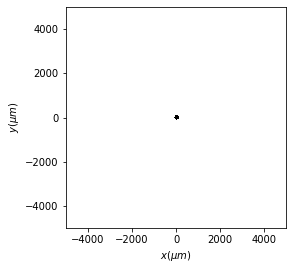

In [17]:
mask.draw(kind='intensity')

In [9]:
# propagate to first lens
A0f1 = A0.RS(z=f1, new_field=True)

# b = f1*3.8317/(k*a) # bright trap
b = f1*jn_zeros(0,1)[0]/(k*a) # dark trap

x1fp = w/2
x2fp = 2*b # maximum fov we care about in Fourier plane
z12 = f1
minpts = int(w*2*(x1fp + x2fp)/(lmbda*sqrt((x1fp + x2fp)**2 + z12**2))+0.5)
A0f1,xpts,ypts = check_samp(A0f1,x1fp,x2fp,z12,w,pts,lmbda,draw=False,onlycheck=True)
pts = len(xpts)

lens1 = Scalar_mask_XY(xpts, ypts, lmbda)
lens1.lens(
    r0=(0, 0),
    radius=(w/2, w/2),
    focal=(f1, f1),
    angle=0)

min pts req'd: 977
current pts: 2048


In [10]:
# transform to Fourier plane
A1 = (A0f1*lens1).RS(z=f1, new_field=True)
# A1.draw()
# A1.draw_profile(point1=(-w/2,0),point2=(w/2,0))

In [12]:
jn_zeros(0,1)[0]

2.404825557695773

In [11]:
# apply the Fourier filter
maskb = Scalar_mask_XY(xpts, ypts, lmbda)
maskb.circle(r0=(0,0), radius=(b, b), angle=0)

A1 = A1*maskb
# A1.draw_profile(point1=(-w/2,0),point2=(w/2,0))

(array([-5000.        , -4998.30508475, -4996.61016949, ...,
         4996.61016949,  4998.30508475,  5000.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 (-5000.0, 0),
 (5000.0, 0))

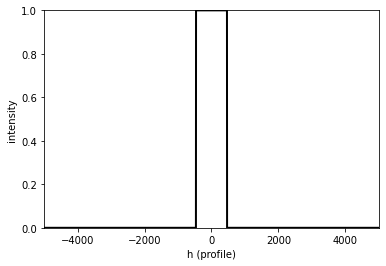

In [19]:
maskb.draw_profile(point1=(-w/2,0),point2=(w/2,0))

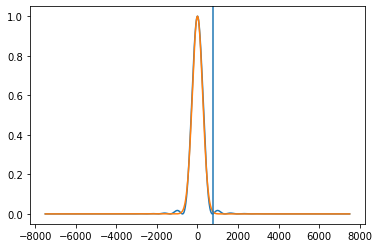

In [15]:
airydisk = lambda x: (2*jn(1,x*k*a/f1)/(x*k*a/f1))**2
plt.plot(xpts, airydisk(xpts))
wAD = 0.84*lmbda*f1/(2*a) # the waist of a Gaussian approx to the Airy disk
gaussian = lambda x: exp(-2*(x/wAD)**2)
plt.plot(xpts,gaussian(xpts))
# plt.axvline(1.5*wAD)

In [12]:
# propagate the masked Fourier field to lens2 - warning: takes ~ 10 minutes
x1fp = b
wAD = 0.84*lmbda*f1/(2*a) # the waist of a Gaussian approx to the Airy disk
zR = pi*wAD**2/lmbda # effective Rayleigh range
wLens2 = wAD*sqrt(1+(f2/zR)**2) # the approximate waist on lens2
x2fp = 1.5*wLens2 # estimate the extent of the field we need care about on lens2
z12 = f2
A1,xpts,ypts = check_samp(A1,x1fp,x2fp,z12,w,pts,lmbda,draw=False)
pts = len(xpts)
print("propagating...")
A1f2 = A1.RS(z=f2,new_field=True)

min pts req'd: 5901
current pts: 2048
resampling with 5901 pts...
propagating...


In [13]:
x1fp = 1.5*wLens2 # the previous x2fp
x2fp = 20*um # estimate the extent of the field we need care about in the image plane
z12 = f2
# A1f2,xpts,ypts = check_samp(A1f2,x2fp,10*um,z12,w,pts,lmbda,draw=False,onlycheck=True)
# pts = len(xpts)

lens2 = Scalar_mask_XY(xpts, ypts, lmbda)
lens2.lens(
    r0=(0, 0),
    radius=(w/2, w/2),
    focal=(f2, f2),
    angle=0)
print("propagating...")
A2 = (A1f2*lens2).RS(z=f2,new_field=True)

propagating...


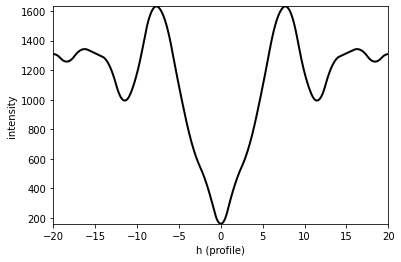

In [14]:
xout,yout,pt1,pt2 = A2.draw_profile(point1=(-20*um,0),point2=(20*um,0))

In [15]:
soln_to_csv('rs_dark_f1_150mm_f2_5mm_a_100um.csv',data=[list(xout),list(yout)],labels=None)#['x [um]','y [arb.]'])

wrote data to rs_dark_f1_150mm_f2_5mm_a_100um.csv


In [31]:
soln_to_csv?

In [27]:
(xout.reshape(1,-1)).shape

(1, 8192)

(array([-500.        , -499.02248289, -498.04496579, ...,  498.04496579,
         499.02248289,  500.        ]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 (-500, 0),
 (500, 0))

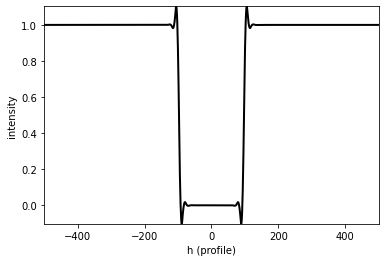

In [10]:
mask.draw_profile(point1=(-500,0),point2=(500,0)) # (kind='intensity')

10000.0


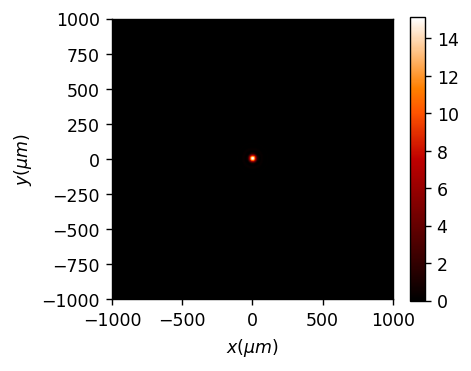

In [9]:
#Field at first lens (f=f1) => u2
f1 = 100*a
print(f1)
u2 = u1.RS(z=f1, new_field=True)

#First lens (f=f1) => t1
t1 = Scalar_mask_XY(x, y, wavelength)
t1.lens(
    r0=(0 * um, 0 * um),
    radius=(w/2,w/2),
    focal=(f1, f1),
    angle=0 * degrees)


#Field propagating through first lens => u3
u3=t1*u2

#Field in the fourier plane => u4
u4 = u3.RS(z=f1, new_field=True)
#u4.cut_resample(
#    x_limits=(-200 * um, 200 * um),
#    y_limits=(-200 * um, 200 * um),
#    num_points=(512, 512),
#    new_field=False)
u4.draw(kind='intensity', logarithm=False,has_colorbar='vertical');

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x1802170e4c0>)

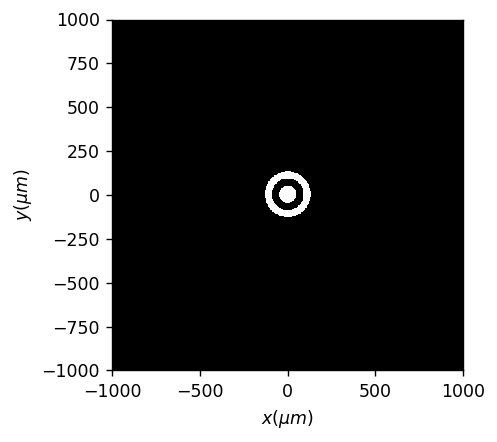

In [12]:
b1 = f1*3.8317/(a*k) #radius of slit in fourier plane
b2= f1*7.0156/(a*k)
b3= f1*10.1735/(a*k)

#Fourier plane filter
c2 = Scalar_mask_XY(x, y, wavelength)
c2.circle(
    r0=(0 * um, 0 * um), radius=(b3, b3), angle=0 * degrees)


r2 = Scalar_mask_XY(x, y, wavelength=wavelength)
r2.ring(
    r0=(0 * um, 0 * um),
    radius1=(b1, b1),
    radius2=(b2, b2),
    angle=0 * degrees)

t2a=c2-r2

t2a.draw()

# t2b = Scalar_mask_XY(x, y, wavelength)
# t2b.circle(
#     r0=(0 * um, 0 * um), radius=(b1, b1), angle=0 * degrees)
# t2b.draw(title='Fourier plane filter - Circle at first 0')


In [2]:
Scalar_mask_XY.lens?

In [13]:
#Field passing through the fourier plane => u5
u5a=t2a*u4
# u5b=t2b*u4

f2=f1/100
#Field at the second lens (f=f2)
u6a = u5a.RS(z=f2, new_field=True)
# u6b = u5b.RS(z=f2, new_field=True)

#Second lens (f=f2) => t3
t3 = Scalar_mask_XY(x, y, wavelength)
t3.lens(
    r0=(0 * um, 0 * um),
    radius=(-1 * size, 1 * size),
    focal=(f2, f2),
    angle=0 * degrees)

#Field propagating through second lens => u7
u7a=t3*u6a
# u7b=t3*u6b

#Field in the image plane =>u8
u8a = u7a.RS(z=f2, new_field=True)
# u8b = u7b.RS(z=f2, new_field=True)

u8a.cut_resample(
    x_limits=(-120 * um, 120 * um),
    y_limits=(-120 * um, 120 * um),
    num_points=(1024, 1024),
    new_field=False)

# u8b.cut_resample(
#     x_limits=(-120 * um, 120 * um),
#     y_limits=(-120 * um, 120 * um),
#     num_points=(1024, 1024),
#     new_field=False)

(array([-15.        , -14.97067449, -14.94134897, ...,  14.94134897,
         14.97067449,  15.        ]),
 array([0.08878976, 0.0653202 , 0.04696286, ..., 0.04696286, 0.0653202 ,
        0.08878976]),
 (-15, 0),
 (15, 0))

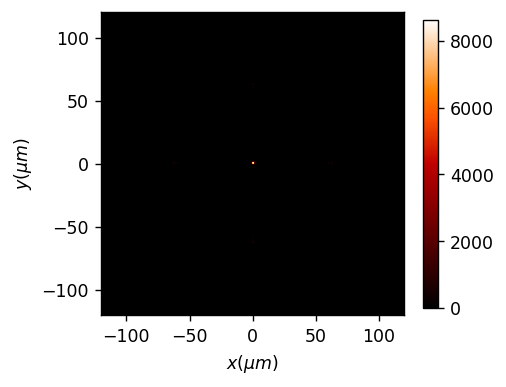

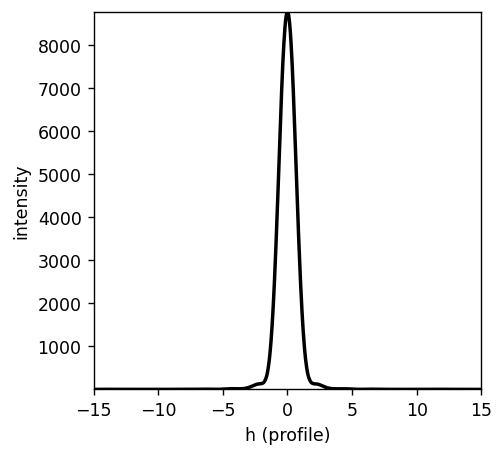

In [14]:
# u8a.normalize()
u8a.draw(kind='intensity', logarithm=False, has_colorbar='vertical')
# u8b.draw(kind='intensity', logarithm=False, has_colorbar='vertical', title='Img Plane (Circle fourier plane)')

u8a.draw_profile(point1=(-15, 0), point2=(15, 0), kind='intensity', order=2)
# u8b.draw_profile(point1=(-15, 0), point2=(15, 0), kind='intensity', order=2)

# h, profile, p1, p2 = t1.profile(
#     point1=(-50, 0), point2=(50, 0), kind='intensity', order=1)
# plt.plot(h, profile, 'r', lw=2);

95.5


(array([-7.45      , -7.44514816, -7.44029632, ...,  7.44029632,
         7.44514816,  7.45      ]),
 array([1.00000000e+00, 9.95603748e-01, 9.91142134e-01, ...,
        3.44412508e-05, 3.50309597e-05, 3.56249065e-05]),
 (0.1, 0),
 (15, 0))

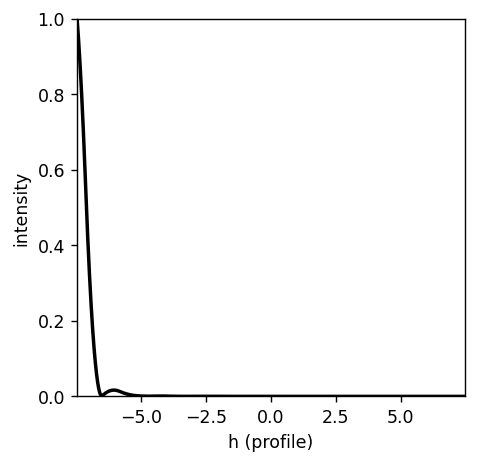

In [74]:
z10= (f2 - 4.5* um) 
print(z10)
u10 = u7a.RS(z=z10, new_field=True)
u10.normalize(kind='intensity')
u10.draw_profile(point1=(0.1, 0), point2=(15, 0), kind='intensity', order=2)